<a href="https://colab.research.google.com/github/mcurcio5/OOTM-Option-Pricing-with-Power-Laws-and-News/blob/master/HawkesProcess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hawkes Processes for earnings
This notebook investigates how earnings reports change the parameters of the Hawkes processes fitting the motion of different Technology stocks. 

Implementation 1 shows a single-variable Hawkes process with a power law kernel, which works but is not applicable to the dataset.

Implementation 2 shows a bivariate Hawkes process (+ and - movements) with an exponential kernel. The code is vectorized and runs fast. It is applicable to the data as it considers the size of the movements (marks) when determining how the event changes the process' intensity.

Later, I will add a second kernel explaining changes in the point process due to preplanned corperate news releases, such as earnings.

I will use this model to value near-term OOTM options around corperate events via simulation.

In [1]:
# mount Google Drive to Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

FOLDERNAME = 'Colab/Projects/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

%cd drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/Colab/Projects


In [2]:
!pip install finnhub-python

In [9]:
import requests
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import timezone, datetime, timedelta
import finnhub
from scipy.optimize import minimize, SR1, Bounds

## Quick look at datasource (FinnHub API)

Showing what data is available for the stocks. Skip forward for Hawkes Processes.

In [4]:
# my finhub API token
token = 'bsoarofrh5re01t4f9a0'
finnhub_client = finnhub.Client(api_key=token)

In [ ]:
df = pd.DataFrame(finnhub_client.company_basic_financials('AAPL', 'margin'))
df.head()

,metric,metricType,symbol
freeOperatingCashFlow/revenue5Y,19.40911,margin,AAPL
freeOperatingCashFlow/revenueTTM,21.05369,margin,AAPL
grossMargin5Y,38.71825,margin,AAPL
grossMarginAnnual,37.81777,margin,AAPL
grossMarginTTM,38.18781,margin,AAPL


In [ ]:
d = finnhub_client.company_executive('AAPL')
df = pd.DataFrame(d['executive'])
df.head()

,age,compensation,currency,name,position,sex,since
0,69.0,557922.0,USD,Dr. Arthur Levinson,Independent Chairman of the Board,male,2011
1,59.0,11555466.0,USD,Mr. Timothy Cook,"Chief Executive Officer, Director",male,2011
2,56.0,25209637.0,USD,Mr. Luca Maestri,"Chief Financial Officer, Senior Vice President",male,2014
3,56.0,25207919.0,USD,Mr. Jeffrey Williams,Chief Operating Officer,male,2018
4,55.0,25231800.0,USD,Ms. Katherine Adams,"Senior Vice President, General Counsel, Secretary",female,2017


In [ ]:
print(finnhub_client.company_peers('AAPL'))

['AAPL', 'DELL', 'HPQ', '1337.HK', 'HPE', 'WDC', 'NTAP', 'PSTG', 'XRX', 'NCR']


In [ ]:
d = finnhub_client.financials_reported(symbol='AAPL')
df = pd.DataFrame(d['data'])

In [ ]:
finnhub_client.company_profile(symbol='AAPL')

In [ ]:
import time

d = finnhub_client.etfs_holdings('SPY')
df = pd.DataFrame(d['holdings'])
profiles = []
for symbol in df['symbol']:
  profiles.append(finnhub_client.company_profile(symbol=symbol))
  time.sleep(1)
  print("added:",symbol)

In [ ]:
df['gsector'] = [profiles[i]['gsector'] for i in range(len(profiles))]
df.head()

In [ ]:
df['profiles'] = profiles
df.head()

,percent,share,symbol,profiles
0,5.918711,43766308,AAPL,"{'address': '1 Apple Park Way', 'city': 'Cuper..."
1,5.815551,81420240,MSFT,"{'address': '1 Microsoft Way', 'city': 'Redmon..."
2,4.730508,4501968,AMZN,"{'address': '410 Terry Ave N', 'city': 'Seattl..."
3,2.180427,25837586,FB,"{'address': '1601 Willow Rd', 'city': 'Menlo P..."
4,1.710792,3224102,GOOGL,"{'address': '1600 Amphitheatre Pkwy', 'city': ..."


In [ ]:
# get data for S&P companies
d = finnhub_client.etfs_holdings('SPY')
df = pd.DataFrame(d['holdings'])
df2 = pd.DataFrame()
for i in range(len(profiles)):
  df2 = df2.append(pd.DataFrame(list([profiles[i].values()]), columns=list(profiles[i].keys())))
df2['symbol'] = df2['ticker']
df2 = df2.drop('ticker', axis=1)
df3 = df.merge(df2, on='symbol')

In [ ]:
#df3.to_csv('./SP500_info.csv')

In [ ]:
df3 = pd.read_csv('./SP500_info.csv')
tech = df3.loc[df3['finnhubIndustry'] == 'Technology']

In [ ]:
tech.head()

,Unnamed: 0,percent,share,symbol,address,city,country,currency,cusip,description,employeeTotal,exchange,finnhubIndustry,ggroup,gind,gsector,gsubind,ipo,isin,logo,marketCapitalization,naics,naicsNationalIndustry,naicsSector,naicsSubsector,name,phone,sedol,shareOutstanding,state,weburl
0,0,5.918711,43766308,AAPL,1 Apple Park Way,Cupertino,US,USD,037833100,"Apple, Inc. engages in the design, manufacture...",137000.0,NASDAQ NMS - GLOBAL MARKET,Technology,Technology Hardware & Equipment,"Technology Hardware, Storage & Peripherals",Information Technology,"Technology Hardware, Storage & Peripherals",1980-12-12,US0378331005,https://static.finnhub.io/logo/87cb30d8-80df-1...,1900306.0,Communications Equipment Manufacturing,Radio and Television Broadcasting and Wireless...,Manufacturing,Computer and Electronic Product Manufacturing,Apple Inc,1.408996e+10,2046251,4275.634000,CALIFORNIA,https://www.apple.com/
1,1,5.815551,81420240,MSFT,1 Microsoft Way,Redmond,US,USD,594918104,Microsoft Corp. engages in the development and...,144000.0,NASDAQ NMS - GLOBAL MARKET,Technology,Software & Services,Software,Information Technology,Systems Software,1986-03-13,US5949181045,NaN,1637262.0,Software Publishers,Software Publishers,Information,Publishing Industries (except Internet),Microsoft Corp,1.425883e+10,2588173,7567.652935,WASHINGTON,https://www.microsoft.com/en-us
6,6,1.228678,18128360,V,PO Box 8999,San Francisco,US,USD,92826C839,"Visa, Inc. engages in the provision of digital...",19500.0,"NEW YORK STOCK EXCHANGE, INC.",Technology,Software & Services,IT Services,Information Technology,Data Processing & Outsourced Services,2008-03-19,US92826C8394,https://static.finnhub.io/logo/96a1dba6-80ec-1...,417827.6,Activities Related to Credit Intermediation,"Financial Transactions Processing, Reserve, an...",Finance and Insurance,Credit Intermediation and Related Activities,Visa Inc,1.650432e+10,B2PZN04,2129.583923,CALIFORNIA,https://usa.visa.com/
11,11,0.994138,9481316,MA,2000 Purchase St,Purchase,US,USD,57636Q104,"Mastercard, Inc. operates as a technology comp...",18600.0,"NEW YORK STOCK EXCHANGE, INC.",Technology,Software & Services,IT Services,Information Technology,Data Processing & Outsourced Services,2006-05-25,US57636Q1040,NaN,330490.3,Activities Related to Credit Intermediation,"Financial Transactions Processing, Reserve, an...",Finance and Insurance,Credit Intermediation and Related Activities,Mastercard Inc,1.914249e+10,B121557,1001.060877,NEW YORK,https://investor.mastercard.com/investor-relat...
18,18,0.771999,5170264,ADBE,345 PARK AVE,San Jose,US,USD,00724F101,"Adobe, Inc. engages in the provision of digita...",22634.0,NASDAQ NMS - GLOBAL MARKET,Technology,Software & Services,Software,Information Technology,Application Software,1986-01-08,US00724F1012,https://static.finnhub.io/logo/9b4b19c2-80df-1...,215643.1,Software Publishers,Software Publishers,Information,Publishing Industries (except Internet),Adobe Inc,1.408537e+10,2008154,479.665239,CALIFORNIA,https://www.adobe.com/


In [ ]:
# get earnings dates for all tech stocks in S&P
earnings = []
for i in range(len(tech)):
  earnings.append(pd.DataFrame(finnhub_client.company_earnings(tech['symbol'].iloc[i])))
  #time.sleep(1)
  print(i)

In [ ]:
earnings_df = pd.DataFrame()
for i in len(earnings):
  earnings_df.
earnings[0]

,actual,estimate,period,symbol
0,2.55,2.3052,2020-03-31,AAPL
1,4.99,4.6410,2019-12-31,AAPL
2,3.03,2.8968,2019-09-30,AAPL
3,2.18,2.1420,2019-06-30,AAPL


## Hawkes Processes

In the following section, I fit constraints on a Hawkes process using a quasi-Newton optimization.

To confirm that the determined parameters fit the dataset, I will use parametric bootstrapping. 


I approximate a power law as the sum of exponential functions with power-law weights, to use a recurrence relation that reduces the log-likelihood calculation from $O(N^2)$ to $O(N)$.

$\phi_{PL} (\tau | n, \epsilon, \tau _0) = \frac{n}{Z} \left( \Sigma _{i=0}^{M-1} \left( \frac{1}{\xi _i} \right) ^{1 + \epsilon} e^{-\tau / \xi_i} - S e ^{- \tau / \xi_{-1}} \right)$

for $\xi_i = \tau_0 m^i$ where $-1 \le i \lt M$

Parameter Z makes sure $\int_0^\infty \phi_{PL} (\tau) d\tau = n$ and $S$ makes sure that $\phi_{PL} (0) = 0$, as market participants can only react to events after more than 0 seconds.

In [ ]:
d = get_stock_data('AAPL')
d.head()

,c,h,l,o,s,t,v
0,323.83,323.87,323.76,323.78,ok,1582128300,10709
1,323.95,324.00,323.85,323.85,ok,1582128360,53238
2,323.95,324.06,323.90,323.94,ok,1582128420,22631
3,324.09,324.09,323.88,323.97,ok,1582128480,38680
4,324.18,324.19,324.08,324.08,ok,1582128540,25352


In [45]:
resol = 5
def get_stock_data(ticker, resolution = resol):
  """ for stock symbol, get data
  @param ticker (str): ticker symbol
  @param resolution (int): time resolution of data
  @returns: Pandas DataFrame of stock data
  """
  # unix time stamp
  start = datetime(2020, 1, 1).replace(tzinfo=timezone.utc).timestamp()
  end = datetime(2020, 7, 1).replace(tzinfo=timezone.utc).timestamp()

  # Stock candles
  res = finnhub_client.stock_candles(ticker, resolution, start, end)
  return pd.DataFrame(res)

def get_df(df, resolution = resol):
  """ Cleans data from API into form interpretable for Hawkes Process
  note: this function is really ugly rn but it works. will fix later
  @param df: output from get_stock_data() function
  @returns: pd DataFrame ready for analysis
  """
  df2 = pd.DataFrame()
  df2['diff'] = np.log(df['o']/df['o'].shift(1))
  df2['date'] = df['t'].apply(lambda x: datetime.fromtimestamp(x))
  # make the time stochastic - method from research paper
  df2['date'] = df2['date'].apply(lambda x: x - timedelta(seconds = np.random.uniform(0,resolution*60)))
  df2['v'] = df['v']
  df2['s'] = df['s']
  df2['dt'] = df2['date'] - df2['date'].shift(1)
  df2['dt'] = df2['dt'].apply(lambda x: x.total_seconds())
  len_before = df2.shape[0]
  df2 = df2.drop(df2.loc[df2['s'] != 'ok'].index, axis = 0)
  if (((len_before - df2.shape[0])/len_before) > .1):
    raise ValueError("Over 10% of dataframe returned NA")
  df2 = df2.drop(columns = 's')
  df2 = df2.drop(df2.loc[df2['dt'] > 10000].index, axis=0).iloc[1:]
  #df2 = df2.drop(df2.loc[df2['date'] != df2['date'].shift(1)].index, axis = 0)
  df2['dt'] = df2['dt']/100
  df2 = df2.reset_index(drop=True)

  # get only top 20% of movements
  q1 = df2['diff'].quantile(q=.5)
  q2 = df2['diff'].quantile(q=.5)
  # create mask for top 20% movement
  df2['event'] = 0
  df2.loc[(df2['diff'] < q1) | (df2['diff'] > q2), 'event'] = 1
  # calculate trading time between events (end of day is looped into next day)
  df2 = df2.reset_index(drop=True)
  l = df2.loc[df2['event']==1].index
  df2['dt_event'] = 0
  for i in range(1,len(l)):
    df2['dt_event'].iloc[l[i]] = np.sum(df2['dt'].iloc[l[i-1]:l[i]])
  df2 = df2.loc[df2['event']==1].reset_index(drop=True)
  df2['time_elapsed'] = 0
  prev = 0
  for i in range(1,df2.shape[0]):
    prev += df2['dt_event'].iloc[i]
    df2['time_elapsed'].iloc[i] = prev
  df2['pos'] = 0
  df2.loc[df2['diff'] > 0, 'pos'] = 1
  df2['diff'] = np.abs(df2['diff'])
  return df2

In [46]:
df = get_df(get_stock_data('SPY'))
df.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,diff,date,v,dt,event,dt_event,time_elapsed,pos
0,0.000735,2019-08-21 13:30:09.484147,641133,1.552039,1,0.000000,0.000000,0
1,0.000120,2019-08-21 13:38:43.076054,786611,5.135919,1,1.552039,1.552039,1
2,0.001607,2019-08-21 13:40:42.093281,693535,1.190172,1,5.135919,6.687958,1
3,0.000512,2019-08-21 13:45:58.319090,438512,3.162258,1,1.190172,7.878130,0
4,0.000017,2019-08-21 13:50:47.847230,395715,2.895281,1,3.162258,11.040389,1


,diff,date,v,dt,event,dt_event,time_elapsed,pos
0,0.001607,2019-08-21 13:40:52.766180,693535,1.418338,1,7.532347,7.532347,1
1,0.000582,2019-08-21 14:16:22.936260,292232,2.647936,1,2.571616,27.604450,1
2,0.000462,2019-08-21 14:46:25.995828,241797,1.990667,1,6.348266,46.292314,1
3,0.000496,2019-08-21 14:50:43.712066,164470,2.577162,1,1.990667,48.282981,1
4,0.001026,2019-08-21 15:05:57.049656,302881,3.138057,1,8.572481,56.855463,1
...,...,...,...,...,...,...,...,...
6471,0.000357,2020-06-30 21:12:03.540279,412669,2.171289,1,5.110737,64721.606713,1
6472,0.000389,2020-06-30 22:12:14.826822,16277,2.716136,1,35.568018,64757.174731,1
6473,0.001005,2020-06-30 22:29:44.888553,9274,5.488878,1,2.727848,64764.902607,1
6474,0.000616,2020-06-30 23:08:30.189750,5088,3.010500,1,9.500051,64790.633997,1


In [25]:
def get_alpha_cont(X):
  """ gets alpha paramter for continuous power law distribution
  @param X (np.array): just holds diff
  """
  n = len(X)
  xmin = X[0]
  a = 1 + n / np.sum(np.log(X / xmin))
  return a

def get_a_range(a, N):
  """ gets 95% confidence interval on alpha paramter estimate
  @param a: alpha
  @param N: number of samples in power law distribution
  @returns a_lower, a_upper: lower and upper bound on alpha 95% CI
  """
  stdev = (a-1)/np.sqrt(N)
  a_lower, a_upper = ((a-stdev*2), (a+stdev*2))
  return a_lower, a_upper

# CODE TO CHECK WHETHER POWER LAW

# for a stock, calculate xmin, alpha, KS stat and determine whether power law
def calc_emperical(df_sorted):
  """ determines whether a power law fits the dataset
  @param df_sorted: price change dataframe sorted from most frequent to least frequent
  @returns p: p-value of fit for power law. p < .1 indicates not a power law.
  p-value above .1 indicates either power law (could exponential or lognormal if N<200)
  """
  # get quantile, alpha, and KS for best fit
  q, a, KS, xmin = get_xmin(df_sorted)
  print("True q: %s a: %s KS: %s xmin: %s" % (q,a,KS,xmin))
  p = calc_fit(df_sorted, q, a, KS, xmin)
  print("p: ",p)
  return p

def calc_fit(df_sorted, q, a, KS, xmin):
  """ determines whether dataset fits power law
  @param df_sorted: price change dataframe sorted from most frequent to least frequent
  @param q: quantile for karmatta point
  @param a: alpha of dataset
  @param KS: Kolgoromov Smirnoff statistic for fit
  @param xmin: minimum x-value for power law data determined by get_xmin()
  @returns p: p-value of fit explained in calc_empirical doc 
  """
  KS_stats = []
  for i in range(2500):
    df = generate_dataset(df_sorted,q,a,xmin)
    q_local, a_local, KS_local, xminlocal = get_xmin(df)
    KS_stats.append(KS_local)
  KS_stats=np.array(KS_stats)
  p = np.mean(KS_stats > KS)
  return p

def generate_dataset(df_sorted,q,a,xmin):
  """ generates synthetic dataset with q,a,xmin
  @returns df: synthetic dataset frame
  """
  N = df_sorted.shape[0]
  df_below_xmin = df_sorted.loc[df_sorted['prob'] >= q]
  # number of samples to generate from power law
  n_power = np.sum(np.random.uniform(0,1,N)<q)
  # number of samples to bootstrap from original dataset > q
  n_normal = N - n_power
  # generate power law variables
  r = np.random.uniform(0,1,n_power)
  x1 = xmin * (1 - r) ** (-1 / (a - 1))
  # bootstrap n_normal variables from df_below_xmin
  x2 = np.random.choice(df_below_xmin['diff'], n_normal, replace=True)
  # make new dataframe
  df = df_sorted.drop(['diff'], axis=1)
  df['diff'] = list(np.sort(np.concatenate((x1,x2),axis=0)))
  return df

def get_xmin(df_sorted):
  """ finds xmin value, quantile, alpha, and KS-stat for emperical distribution.
  @param df_sorted: df sorted by quantile, either negative or positive changes
  @return: quantile, alpha param, KS-stat, xmin
  """
  quants = [.5,.35,.2, .14, .10, .07, .035] # 100% of data - min quantile
  D, alphas1 = calc_KS(df_sorted, quants)
  sorted = list(np.argsort(D))
  num_searches = 6 # number of searches over smaller range
  # get quantiles of refined search range
  quants = list(np.linspace(quants[sorted[0]]-.025, quants[sorted[0]]+.025, num = num_searches))
  D2, alphas2 = calc_KS(df_sorted, quants)
  index = np.argmin(D2)
  # get quantile of best KS stat
  quant = np.round(quants[index], 3)
  # get alpha of that quantile
  alpha = alphas2[index]
  # get KS of that quantile
  KS = D2[index]
  # get minimum change in power law
  xmin = df_sorted['diff'].loc[df_sorted['prob'] < quant].iloc[0]
  return quant, alpha, KS, xmin

def calc_KS(df_sorted, quantiles):
  """ Calculate Kolmogorov-Smirnov Statistic for goodness of fit test using 
  CDF for continuous power law
  @param df_sorted: sorted dataframe
  @param quantiles: quantiles to test in df_sorted
  @return D: Distances measured by KS-stat
  @return alphas: alpha parameters corresponding to D[i] quantiles 
  """
  D = []
  alphas = []
  for i in range(len(quantiles)):
    # get subset for min quantile
    df = df_sorted.loc[df_sorted['prob'] < quantiles[i]]
    X = df['diff'].to_numpy()
    a = get_alpha_cont(X) # get alpha for that subset
    alphas.append(a)
    # calculate emperical cdf for subset
    df['emp_cdf'] = 1 - np.arange(df.shape[0])/df.shape[0]
    # get real cdf for continuous power law
    xmin = df['diff'].iloc[0]
    df['true_cdf'] = (df['diff']/xmin)**(-a + 1)
    # get KS Statistic on subset
    D.append(np.max(np.abs(df['emp_cdf'] - df['true_cdf'])/np.sqrt(df['true_cdf']*(1 - df['true_cdf']))))
  return D, alphas


# CODE SHOWS POWER LAW
# function to print power laws for stock
def show_power_law(neg_sorted = None, pos_sorted = None, ax = None):
  """ prints graph of power law for price daily price changes in stock
  @param ax: matplotlib axes for the graph
  """
  if (neg_sorted is None) and (pos_sorted is None):
    raise SyntaxError("Must provide some dataframe")
  if ax is None:
    ax = plt.gca()

  if (neg_sorted is not None):
    # sort by move size and calculate cdf
  
    q, alpha_hat, KS, xmin = get_xmin(neg_sorted)
    print(q, alpha_hat, KS, xmin)
    select_df = neg_sorted.loc[neg_sorted['prob'] < q]
    select_df = select_df.reset_index(drop=True)
    size = select_df.shape[0]

    # neg sorted slope
    x = np.linspace(np.min(select_df['diff']), np.max(select_df['diff']),num=50)
    k = select_df.loc[0,'prob'] * (x[0] ** (alpha_hat))
    y = k * (x ** (-alpha_hat))
    # plot 
    ax.plot(neg_sorted['diff'], neg_sorted['prob'], '.', c='red', markeredgecolor='none')
    ax.plot(x,y)

    sigma_a = get_a_range(alpha_hat,size)
    print("neg alpha range:",sigma_a)
    textstr = r'$\alpha_-$ = %s %sN=%s' % (np.round(alpha_hat, 2),'\n',size)
    ax.annotate(textstr, xy=(x[0], y[0]), xytext=(x[0]+.02, y[0]+.3),
            arrowprops=dict(facecolor='black', shrink=0.1))

  if (pos_sorted is not None):
    q, alpha_hat2, KS, xmin = get_xmin(pos_sorted)
    print(q,alpha_hat2,KS, xmin)
    select_df = pos_sorted.loc[pos_sorted['prob'] < q]
    select_df = select_df.reset_index(drop=True)
    size2 = select_df.shape[0]

    x_pos = np.linspace(np.min(select_df['diff']), np.max(select_df['diff']),num=50)
    k = select_df['prob'][0] * (x_pos[0] ** (alpha_hat2))
    y_pos = k * (x_pos ** (-alpha_hat2))

    ax.plot(pos_sorted['diff'], pos_sorted['prob'], '.', c='blue', markeredgecolor='none')
    ax.plot(x_pos, y_pos)

    sigma_a = get_a_range(alpha_hat2,size2)
    print("pos alpha range:",sigma_a)
    textstr2 = r'$\alpha_+$ = %s %sN=%s' % (np.round(alpha_hat2, 2),'\n',size2)
    ax.annotate(textstr2, xy=(x_pos[0], y_pos[0]), xytext=(x_pos[0], y_pos[0]+.3),
        arrowprops=dict(facecolor='black', shrink=0.1))

  ax.set_yscale('log')
  ax.set_xscale('log')
  ax.set_xlim(left = 10**-3)
  # ax.set_title(ticker.upper())
  
  return ax

In [ ]:
# import functions used in other notebook
#path = './power_laws.py'
# %load_ext autoreload
# from power_laws import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


0.105 2.8342622163209823 0.12089011145296583 0.001920194630664084
neg alpha range: (2.725226645274478, 2.9432977873674866)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


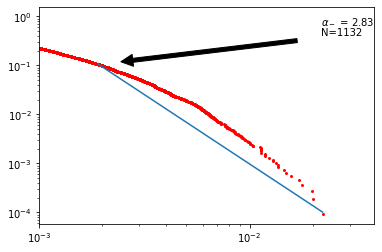

In [49]:
# sort by move size and calculate cdf

df_pos = df.loc[df['pos'] == 1]
pos_sorted = df_pos.sort_values('diff')
pos_sorted['prob'] = 1 - np.arange(pos_sorted.shape[0]) / pos_sorted.shape[0]
pos_sorted = pos_sorted.reset_index(drop=True)

df_neg = df.loc[df['pos'] == 0]
neg_sorted = df_neg.sort_values('diff')
neg_sorted['prob'] = 1 - np.arange(neg_sorted.shape[0]) / neg_sorted.shape[0]
neg_sorted = neg_sorted.reset_index(drop=True)

# pos_sorted.tail()
# 
#calc_emperical(pos_sorted)
show_power_law(neg_sorted=neg_sorted)
#neg_pos_sortedsorted.loc[:,'diff'].to_numpy()

0.125 2.653777632900618 0.10451217538063708 0.0015903426202225313
pos alpha range: (2.5637240213404726, 2.7438312444607633)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


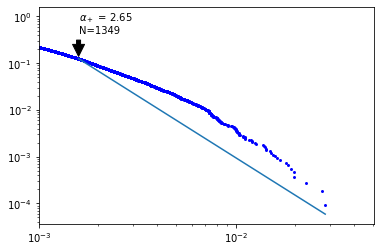

In [50]:
show_power_law(pos_sorted=pos_sorted)

In [51]:
# verify that it's a power law
p = calc_emperical(pos_sorted)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


True q: 0.125 a: 2.653777632900618 KS: 0.10451217538063708 xmin: 0.0015903426202225313
p:  0.056


In [52]:
# not a power law... trying negative
p = calc_emperical(neg_sorted)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


True q: 0.105 a: 2.8342622163209823 KS: 0.12089011145296583 xmin: 0.001920194630664084
p:  0.046


While the graph may look like a power law, it is not the best fit for stock price movements at the 5 minute time frame. This makes sense as stocks have limits on how far they can move in 5 minutes. An exponential or lognormal distribution might fit the data better. I will try to fit a gamma distribution using MLE.

That being said, the influence of an event on the intensity of a Hawkes process might still decay at a power law rate, which is what I will investigate next.

In [ ]:
df.tail()

,diff,date,v,dt,event,dt_event,time_elapsed,pos
10790,0.000389,2020-06-30 22:11:31.609406,16277,2.071046,1,6.076548,64695.642685,1
10791,0.001005,2020-06-30 22:25:02.454424,9274,1.447650,1,8.731846,64704.374531,1
10792,0.000162,2020-06-30 22:32:48.954629,5864,4.665002,1,1.447650,64705.822181,1
10793,0.000616,2020-06-30 23:07:09.775062,5088,2.940487,1,22.332719,64728.154900,1
10794,0.000486,2020-06-30 23:24:32.790392,32190,4.114416,1,9.256224,64737.411124,1


I will define an outlier for the Hawkes process as a point beyond the Karmatta point where movements after follow a power law distribution. Using the power law $\alpha$ obtained from MLE methods, I will optimize the Hawkes process to predict these movements

Hawke's MLE approach from https://arxiv.org/abs/1405.6047

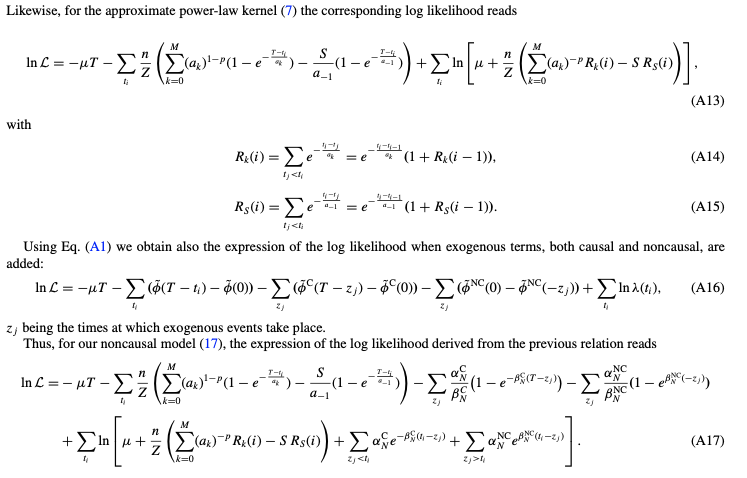

## Implementation 1)
single variable hawkes process modeling timings of large movements. Hawkes process does not apply to the data used right now, but implemenation works.

See implementation 2 for a MUCH cleaner, and efficient implementation.

In [ ]:
# max log likelihood using power law kernel without news kernel
from itertools import *

def pl_likelihood(params, df):
  """ the power law kernel (sum of 15 exponentials) 
  @params (floats): mu, n, p, t0 (see formulas)
  @returns (float): negative log likelihood for those parameters
  """
  mu, n, p, t0 = params
  print("testing mu = %s, n = %s, p = %s, t0 = %s" % (mu,n,p,t0))
  X = df # work around rn
  M = 15
  m = 5
  T = X['time_elapsed'].iloc[-1]
  N = X.shape[0] # number of events
  a_neg1 = t0*m**(-1)
  
  A_cache = dict([(0,t0)])
  def A(k):
    if k in A_cache:
      return A_cache[k]
    A_cache[k] = t0*m**k
    return A_cache[k]

  # calculate S so PL(0) = 0
  # make the first index the first event...
  S = np.sum([(A(k))**(-p) for k in range(M-1)])
  #print("S:",S)

  # calculate integral of phi power law 0 to inf to get Z
  phi_pl = 0

  for i in range(0,N):
    ti = X['time_elapsed'].iloc[i]
    term1 = np.sum([(A(k))**(-p)*np.exp(-ti/(A(k))) for k in range(M-1)])
    phi_pl = phi_pl + n*(term1 - S*np.exp(-ti/a_neg1))
  Z = phi_pl / n
  #print("Z =",Z)

  # def phi(t):
  #   """ power law kernel for t
  #   """
  #   term1 = np.sum([(A(k))**(-p)*np.exp(-t/(A(k))) for k in range(M-1)])
  #   return n/Z*(term1 - S*np.exp(-t/A(-1)))

  # v_phi = np.vectorize(phi)
  # calculate mu

  # AHHHH neither of these methods are efficient... need to calculate mu another way

  # time_elapsed = X['time_elapsed'].to_numpy()
  # differences = [a-b for (a,b) in combinations(time_elapsed,2)]

  # big_lambda = 0
  # times = np.array([0])
  # for i in range(1,N):
  #   ti = X['time_elapsed'].iloc[i]
  #   local_times = np.repeat(ti, i) - time_elapsed[0:i]
  #   times = np.concatenate((times,local_times))

  # ncombos = N*(N-1)/2
  # big_lambda = np.sum(v_phi(differences))/ncombos

  # big_lambda = 0
  # for i in range(1,N):
  #   print(i)
  #   # calculate the t values for list
  #   ti = X['time_elapsed'].iloc[i]
  #   times = np.full((1,i),ti) - X['time_elapsed'].iloc[0:i].to_numpy()
  #   big_lambda += n/Z*(np.sum(v_phi(times)))
  #mu = -big_lambda/(1-(1/(1-n)))

  likelihood = -mu*T

  # memoization speeds it up a lot
  cache = dict([(1,0)])
  def RK(ind,k):
    if ind in cache:
      return cache[ind]
    ti = X['time_elapsed'].iloc[ind]
    ti_minus1 = X['time_elapsed'].iloc[ind-1]
    val = np.exp(-(ti - ti_minus1)/(t0*m**k))*(1+RK(ind-1,k))
    cache[ind] = val
    return val
  
  cache2 = dict([(1,0)])
  def R1(ind):
    if ind in cache2:
      return cache2[ind]
    ti = X['time_elapsed'].iloc[ind]
    ti_minus1 = X['time_elapsed'].iloc[ind-1]
    val = np.exp(-(ti - ti_minus1)/(t0*m**-1))*(1+R1(ind-1))
    cache2[ind] = val
    return val

  for i in range(1,N):
    ti = X['time_elapsed'].iloc[i]
    term1 = np.sum([(A(k))**(1-p)*(1-np.exp(-(T-ti)/(A(k)))) for k in range(0,M)])
    term2 = S/(a_neg1)*(1 - np.exp(-(T - ti)/a_neg1))
    logsum1 = np.sum([(A(k))**(-p)*RK(i,k) for k in range(0,M)])
    #print(R1(i))
    logterm1 = np.log(mu + n/Z*(logsum1 - S*R1(i)))
    likelihood = likelihood - n/Z*(term1 - term2) + logterm1
    #print(likelihood)

  print("Negative Likelihood:",-likelihood) # minimize negative likelihood!!
  return -likelihood # want to maximize likelihood with minimization function


In [ ]:
from scipy.optimize import SR1, Bounds

#set initial value guesses for mu, n, p, t0. (.7,.9),(1.2,1.4),(1.2,3)
rand = np.random.uniform
params = np.array([rand(0,.5),rand(),rand(1,2),rand(1,2)])
# set linear constraint
bounds = Bounds([0, 0, 1.0, .6],[.5, 1.1, 2, 5])
res = minimize(pl_likelihood, params, method="L-BFGS-B",bounds = bounds)

testing mu = 0.10946462169781729, n = 0.9946532122069717, p = 1.4650995566944485, t0 = 1.30671918616262
Negative Likelihood: -88783.23824219174
testing mu = 0.10946463169781728, n = 0.9946532122069717, p = 1.4650995566944485, t0 = 1.30671918616262
Negative Likelihood: -88783.23777837197
testing mu = 0.10946462169781729, n = 0.9946532222069717, p = 1.4650995566944485, t0 = 1.30671918616262
Negative Likelihood: -88783.2392630905
testing mu = 0.10946462169781729, n = 0.9946532122069717, p = 1.4650995666944484, t0 = 1.30671918616262
Negative Likelihood: -88783.24261165473
testing mu = 0.10946462169781729, n = 0.9946532122069717, p = 1.4650995566944485, t0 = 1.30671919616262
Negative Likelihood: -88783.23430241761
testing mu = 0.0, n = 1.1, p = 2.0, t0 = 0.6


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:102: RuntimeWarning: divide by zero encountered in log


Negative Likelihood: inf
testing mu = 1e-08, n = 1.1, p = 2.0, t0 = 0.6
Negative Likelihood: -8688590.732156882
testing mu = 0.0, n = 1.10000001, p = 2.0, t0 = 0.6
Negative Likelihood: inf
testing mu = 0.0, n = 1.1, p = 2.00000001, t0 = 0.6


/usr/local/lib/python3.6/dist-packages/scipy/optimize/optimize.py:697: RuntimeWarning: invalid value encountered in double_scalars
  df = (f(*((xk + d,) + args)) - f0) / d[k]


Negative Likelihood: inf
testing mu = 0.0, n = 1.1, p = 2.0, t0 = 0.60000001
Negative Likelihood: inf
testing mu = 0.10946462169781729, n = 0.9946532122069717, p = 1.4650995566944485, t0 = 1.30671918616262
Negative Likelihood: -88783.23824219174
testing mu = 0.10946463169781728, n = 0.9946532122069717, p = 1.4650995566944485, t0 = 1.30671918616262
Negative Likelihood: -88783.23777837197
testing mu = 0.10946462169781729, n = 0.9946532222069717, p = 1.4650995566944485, t0 = 1.30671918616262
Negative Likelihood: -88783.2392630905
testing mu = 0.10946462169781729, n = 0.9946532122069717, p = 1.4650995666944484, t0 = 1.30671918616262
Negative Likelihood: -88783.24261165473
testing mu = 0.10946462169781729, n = 0.9946532122069717, p = 1.4650995566944485, t0 = 1.30671919616262
Negative Likelihood: -88783.23430241761


In [ ]:
print(res.x)

[0.10946462 0.99465321 1.46509956 1.30671919]


## Implementation 2

The below function creates a bivariate Hawkes process (+ and - movements) efficiently using vectorization.

I need to fix the starting parameters on the optimization, but the code runs. 

Parts of method borrowed from https://people.math.ethz.ch/~embrecht/ftp/Hawkes_PE_TL_LL.pdf

The Log Likelihood function for a multivariate (dimensions $= d$) and single value marks Hawkes Process:

$\Lambda_j (t) := \int_{T_*}^{t} {\lambda_j (s) ds}$

$\log L = \Sigma _{j=1}^d \int_{DxR} \log \lambda_j (t) N_j (dt \times dx) + \Sigma _{j=1}^d \int _{D\times R} \log f_j (x) N_j (dt \times dx) - \Sigma _{j=1}^d \Lambda_j (T^*)$

In [ ]:
# now fit model that works
# decay function w(t)
def w(t,dirac):
  """ expo() pdf """
  if t < 0:
    return 0
  return dirac*np.exp(-dirac*t)
v_w = np.vectorize(w)

def w_hat(t,dirac):
  """ cdf of expo() """
  if t < 0:
    return 0
  return (1-np.exp(-dirac*t))
v_w_hat = np.vectorize(w_hat)

def g(x, l, b):
  """ normalized impact function where alpha_k =1
  @param x (float): mark of point
  @param l (float): lambda represents rate of expo() dist for mark
  @param b (float): beta represents parameter for impact of mark
  """
  return (l**2 / (l**2 + b*l) * (1 + b*x))
v_g = np.vectorize(g)

pos_cache = dict([(1,0),(0,0),(-1,0)])
neg_cache = dict([(1,0),(0,0),(-1,0)])
def R(length, times, pos, dirac):
  """ breaks up sum with recursion trick 
  @param times (np.array): the arrival times
  @param pos (int): 1 if positive 0 if negative (helps with caching)
  """
  i = length - 1 # calculate index
  if pos:
    if i in pos_cache:
      return pos_cache[i]
    t = times[i] - times[i-1]
    pos_cache[i] = np.exp(-dirac*t)*(1+R((i-1),times,pos,dirac))
    return pos_cache[i]
  if i in neg_cache:
    return neg_cache[i]
  t = times[i] - times[i-1]
  neg_cache[i] = np.exp(-dirac*t)*(1+R((i-1),times,pos,dirac))
  return neg_cache[i]

def multi_likelihood(params):
  """ 
  @param n1,n2 (floats): underlying intensity for process
  @param o11,o12,o21,o22 (floats): branching coefficients in matrix Q
  @param b1,b2 (ints): control impact function - influence of mark on intensity
  @param dirac (float): parameter for decay function w()
  @param l1,l2 (ints): lambda defines expo() pdf of marks
  @returns (float): negative log likelihood for those parameters
  """
  d = 2

  # NOTE: l1,l2 are emperical and based on dataset. not movable parameters

  n1,n2,o11,o12,o21,o22,b1,b2,dirac,l1,l2 = params
  n = np.array([n1,n2])
  o = np.array([[o11,o12],[o21,o22]])
  b = np.array([b1,b2])
  l = np.array([l1,l2])

  # input in array with rows (ti, di, xi) for time, dimension, mark
  X = df.loc[:,['time_elapsed','pos','diff']].to_numpy()
  T = X[-1,0]
  N = X.shape[0] # number of events

  # VECTORIZE EVERYTHING

  # calculate log-likelihood shown above

  # Lambda_j
  likelihood = np.sum([-n[j]*(T) for j in range(d)])
  for j in range(d):
    for k in range(d):
      indices = np.where(X[:-1,1] == j)[0]  # indices where it's positive or negative
      current_ts = T - np.take(X[:-1,0],indices) # get differences of all times
      decay = v_w_hat(current_ts,dirac)
      current_marks = np.take(X[:-1,1],indices)
      impact = v_g(current_marks, l[k], b[k])
      likelihood -= o[j,k]*np.sum(decay*impact)

  # log (lambda_j)
  for j in range(d):
    for i in range(1,N):
      t = X[i,0]
      term1 = 0
      for k in range(d):
        gt = g(t, l[k], b[k])
        indices = np.where(X[:i,1]==j)[0]
        times = np.take(X[:i,0],indices)
        term1 += o[j,k] * gt * R(len(times), times, j, dirac)
      likelihood += np.log(n[j] + term1)

  # log (f_j)
  for j in range(d):
    indices = np.where(X[:i,1]==j)[0]
    marks = np.take(X[:i,2],indices)
    likelihood += np.sum(np.log(v_w(marks,dirac)))

  print("Negative Likelihood:",-likelihood) # minimize negative likelihood!!
  return -likelihood # want to maximize likelihood with minimization function

In [ ]:
#set initial guesses for 11 parameters
# n1,n2,o11,o12,o21,o22,b1,b2,dirac,l1,l2
rand = np.random.uniform
params = np.random.uniform(.1,.9,size=11)
# set linear constraint
bounds = Bounds([0]*11,[np.inf]*11)
#res = minimize(multi_likelihood, params, method="L-BFGS-B",bounds = bounds)
res = minimize(multi_likelihood, params, method='trust-constr',  jac="2-point", 
               hess=SR1(), options={'verbose': 1}, bounds=bounds)